Importing libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Importing Dataset

In [170]:
df = pd.read_csv('./data/Food_insecurity_selected_demographic_characteristics.csv')

Drop unwanted columns

In [171]:
cols_to_drop = [
    'DGUID', 'VECTOR', 'COORDINATE', 'STATUS', 'SYMBOL',
    'TERMINATED', 'UOM_ID', 'SCALAR_FACTOR', 'SCALAR_ID'
]
df.drop(columns=[c for c in cols_to_drop if c in df.columns], inplace=True)
df.head()

,REF_DATE,GEO,Demographic characteristics,Household food security status,Statistics,UOM,VALUE,DECIMALS
0,2018,Canada,All persons,Food insecure,Percentage of persons,Percent,16.8,1
1,2019,Canada,All persons,Food insecure,Percentage of persons,Percent,15.9,1
2,2020,Canada,All persons,Food insecure,Percentage of persons,Percent,15.7,1
3,2021,Canada,All persons,Food insecure,Percentage of persons,Percent,18.4,1
4,2022,Canada,All persons,Food insecure,Percentage of persons,Percent,22.9,1


Rename columns

In [172]:
rename_map = {
    'REF_DATE': 'Year',
    'GEO': 'Region',
    'Household food security status': 'FoodSecurityStatus',
    'Statistics': 'StatisticType',
    'UOM': 'Unit',
    'VALUE': 'Value',
    'DECIMALS': 'Decimals'
}
df.rename(columns=rename_map, inplace=True)

Delete rows with NaN values

In [173]:
df = df.dropna(subset=['Value'])

Drop rows with no target

In [174]:
df = df.dropna(subset=['Value']).reset_index(drop=True)

Make sure 'Year' is numeric

In [175]:
df['Year'] = df['Year'].astype(int)

Feature selection

In [176]:
features = ['Year', 'Demographic characteristics']
target = 'Value'

In [177]:
X = df[features]
y = df[target]

Define preprocessing

In [178]:
categorical = ['Demographic characteristics']
numeric = ['Year']

In [179]:
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical),
        ('num', 'passthrough', numeric)
    ]
)

Build model pipeline

In [180]:
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42))
])

Train-test split and fit

In [181]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaluation

In [182]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print('RMSE:', rmse)

RMSE: 4.381618017886294


Plot Actual vs Predicted

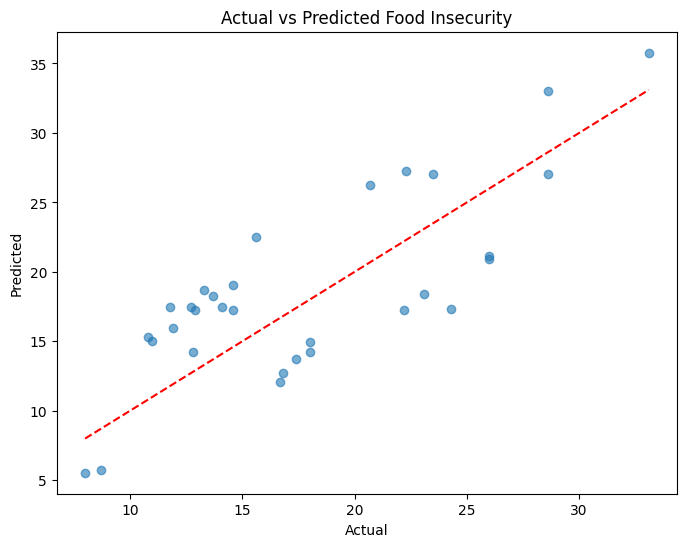

In [183]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Food Insecurity')
plt.show()

Predict future years

In [184]:
future_years = pd.DataFrame({
    'Year': [2025, 2026, 2027, 2028, 2029, 2030],
    'Demographic characteristics': [
        'Total, 12 years and over'
    ] * 6   # predict for same demographic
})

In [185]:
future_predictions = model.predict(future_years)

future_years['Predicted Food Insecurity'] = future_predictions
print(future_years)

   Year Demographic characteristics  Predicted Food Insecurity
0  2025    Total, 12 years and over                   24.18455
1  2026    Total, 12 years and over                   24.18455
2  2027    Total, 12 years and over                   24.18455
3  2028    Total, 12 years and over                   24.18455
4  2029    Total, 12 years and over                   24.18455
5  2030    Total, 12 years and over                   24.18455


Plot historical + future forecast

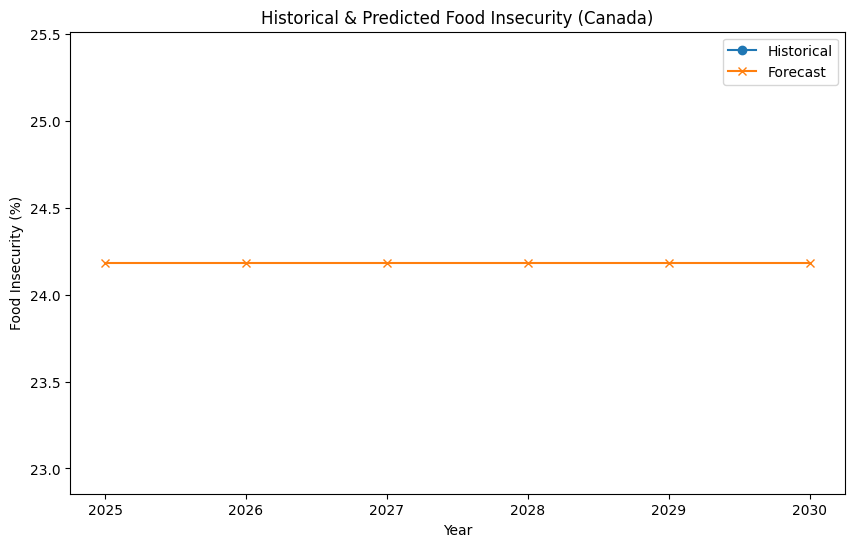

In [186]:
# Aggregate historical for the same demographic
historical = df[df['Demographic characteristics'] == 'Total, 12 years and over']
historical_grouped = historical.groupby('Year')['Value'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(historical_grouped['Year'], historical_grouped['Value'], marker='o', label='Historical')
plt.plot(future_years['Year'], future_years['Predicted Food Insecurity'], marker='x', label='Forecast')
plt.xlabel('Year')
plt.ylabel('Food Insecurity (%)')
plt.title('Historical & Predicted Food Insecurity (Canada)')
plt.legend()
plt.show()